### Asso performance after and before re-writing
Asso: new Asso
AssoOri: legacy code

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

from models import Asso, AssoOri
import pandas as pd
from utils import show_matrix

from cProfile import Profile
from pstats import SortKey, Stats

### Generate Boolean matrix

[I] m            : 1000
[I] n            : 500
[I] k            : 5
[I] overlap_flag : False
[I] size_range   : [0.25 0.75 0.25 1.  ]
[I] seed         : 1234
[I] noise        : [0.5 0.2]
[I] seed         : 1024
[I] Using RandomState.


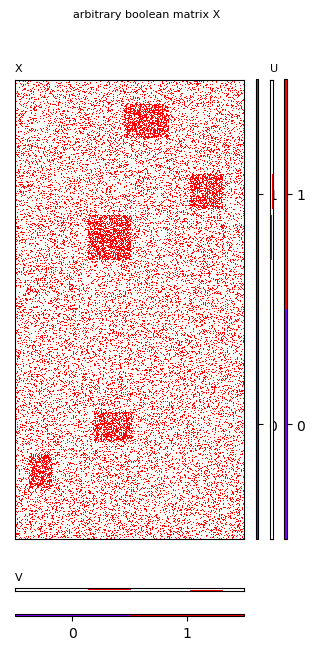

In [12]:
# generate arbitrary Boolean matrix (X)
from generators import BlockDiagonalMatrixGenerator, BlockMatrixGenerator

n_row=1000
n_col=500
k=5
overlap_flag=True
noise=[0.5, 0.2]
size_range=[0.25, 0.75, 0.25, 1.0]

data = BlockMatrixGenerator(m=n_row, n=n_col, k=k, overlap_flag=False, size_range=size_range)
data.generate(seed=1234) # if no seed assigned, use time instead
data.add_noise(noise=noise, seed=1024)
data.to_sparse()
data.show_matrix(scaling=0.2, title='arbitrary boolean matrix X')

In [13]:
X = data.X

### Load MovieLens data

[<943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 <943x81 sparse matrix of type '<class 'numpy.float64'>'
 	with 3499 stored elements in Compressed Sparse Row format>,
 <26x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 4031 stored elements in Compressed Sparse Row format>,
 <4708x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 8306 stored elements in Compressed Sparse Row format>]

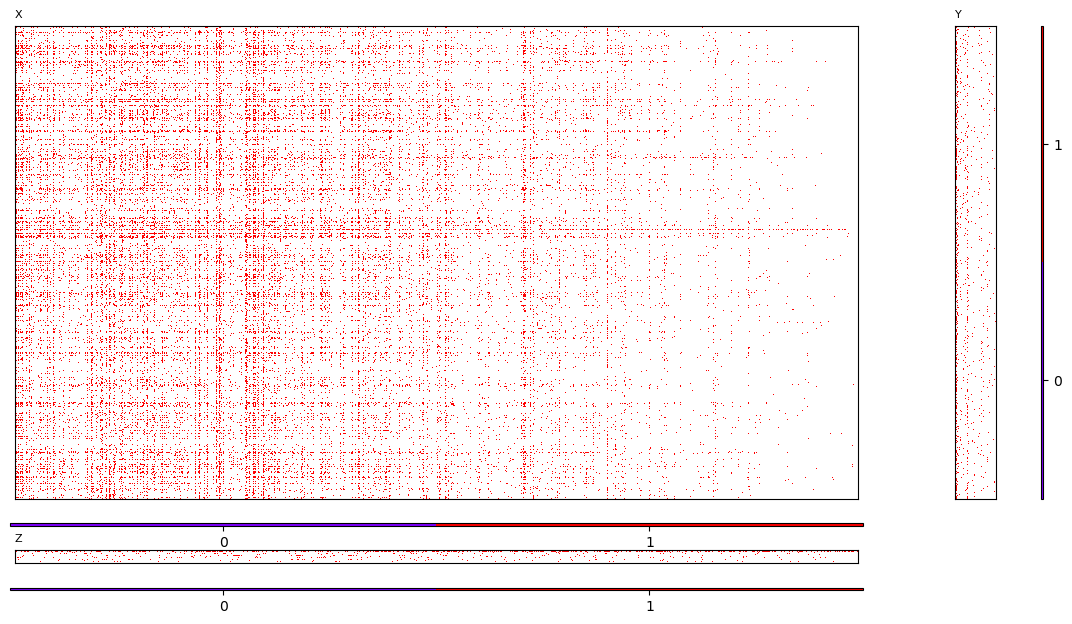

In [3]:
from datasets import MovieLensData, MovieLensGenreCastUserData

data = MovieLensGenreCastUserData(size='100k')

data.load()

# data.sample(factor_id=0, n_samples=300)
# data.sample(factor_id=1, n_samples=300)

display(data.Xs)

X, Y, Z, _ = data.Xs

show_matrix([(X, [0, 0], 'X'), (Y, [0, 1], 'Y'), (Z, [1, 0], 'Z')], 
            colorbar=True, keep_nan=True, discrete=True, center=True, clim=[0, 1], scaling=0.5)

In [15]:
from datasets import NoSplit, RatioSplit

split = RatioSplit(X=X, val_size=0.1, test_size=0.2, seed=1000)
split.negative_sample(train_size=split.pos_train_size, 
                      val_size=split.pos_val_size, 
                      test_size=split.pos_test_size, type='popularity')

X_train, X_val, X_test = split.X_train, split.X_val, split.X_test

[I] RatioSplit, sampling positives
[I]   seed         : 1000
[I]   train_size   : 78146
[I]   val_size     : 11164
[I]   test_size    : 22328
[I]   seed         : 1000
[I] RatioSplit, sampling negatives
[I]   all_negatives: 388362
[I]   n_negatives  : 111638
[I]   train_size   : 78146
[I]   val_size     : 11164
[I]   test_size    : 22328
[I]   seed         : 1000


c:\Users\nieht\Anaconda3\envs\cornac\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


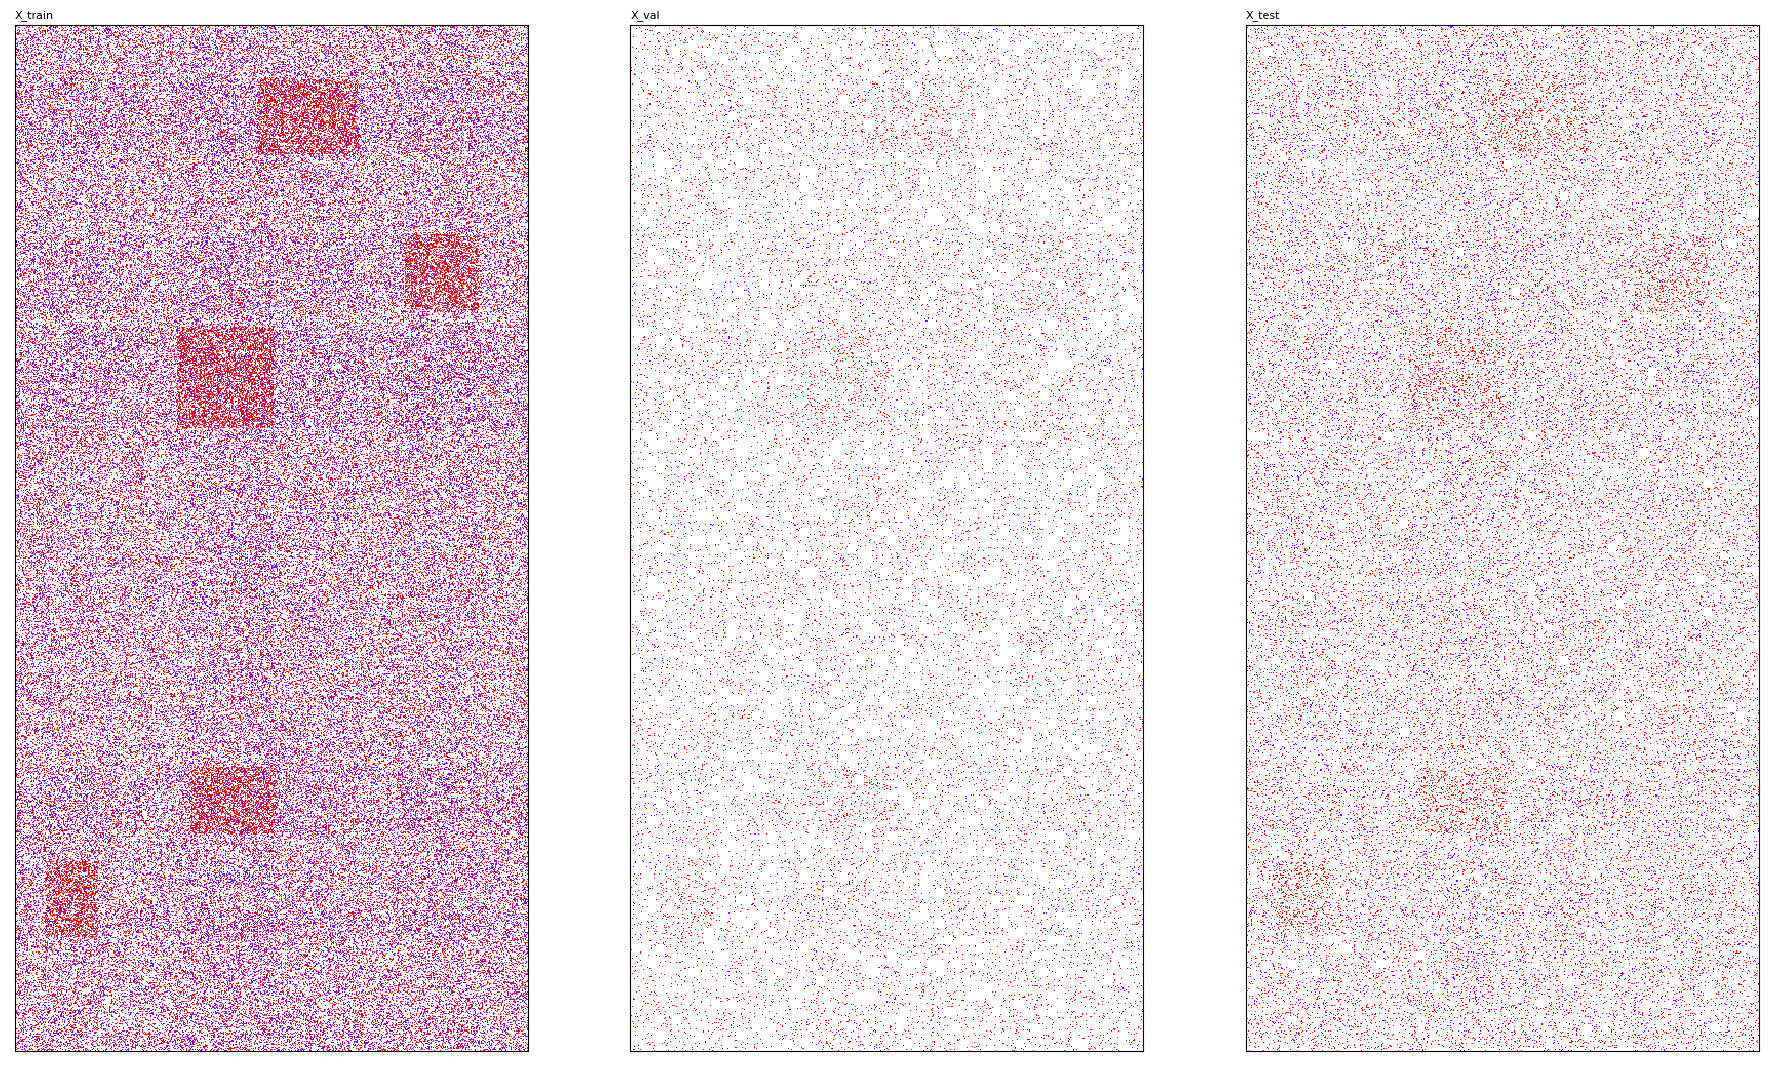

In [16]:
show_matrix(settings=[(X_train, [0, 0], 'X_train'), 
                      (X_val, [0, 1], 'X_val'), 
                      (X_test, [0, 2], 'X_test'), 
                      ], keep_nan=True, clim=[0, 1], discrete=True, center=True)

# AssoOri

In [6]:
# for ml-100k data

k = 1
tau = 0.05
w = 0.25

In [27]:
# for generated data

k = 1
tau = 0.2
w = 0.2

[I] k            : 1
[I] verbose      : False
[I] display      : False
[I] tau          : 0.2
[I] weights      : 0.2
[I] task         : prediction
[I] verbose      : True
[I] display      : True


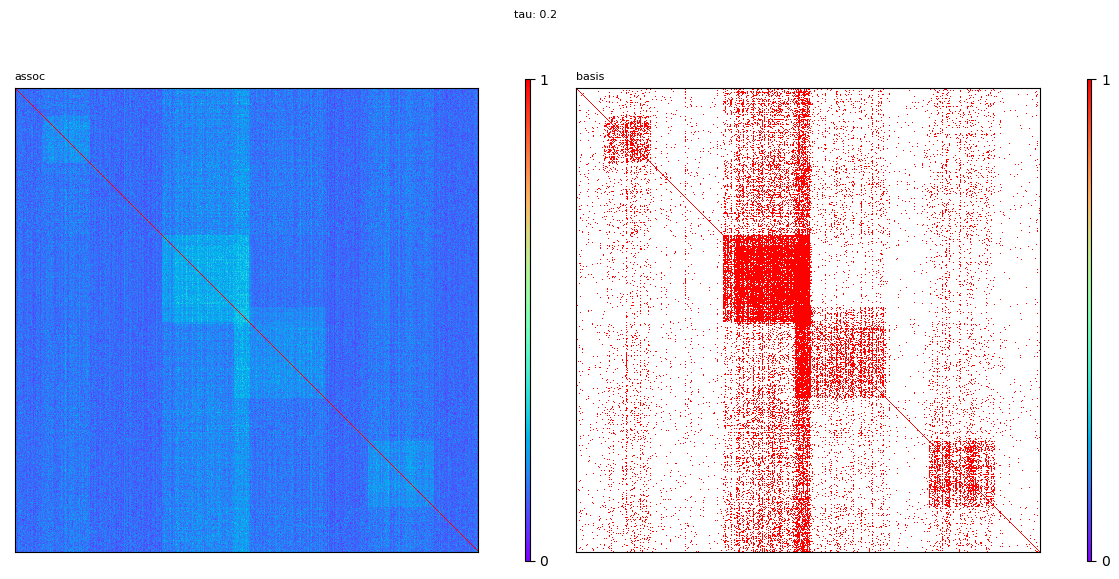

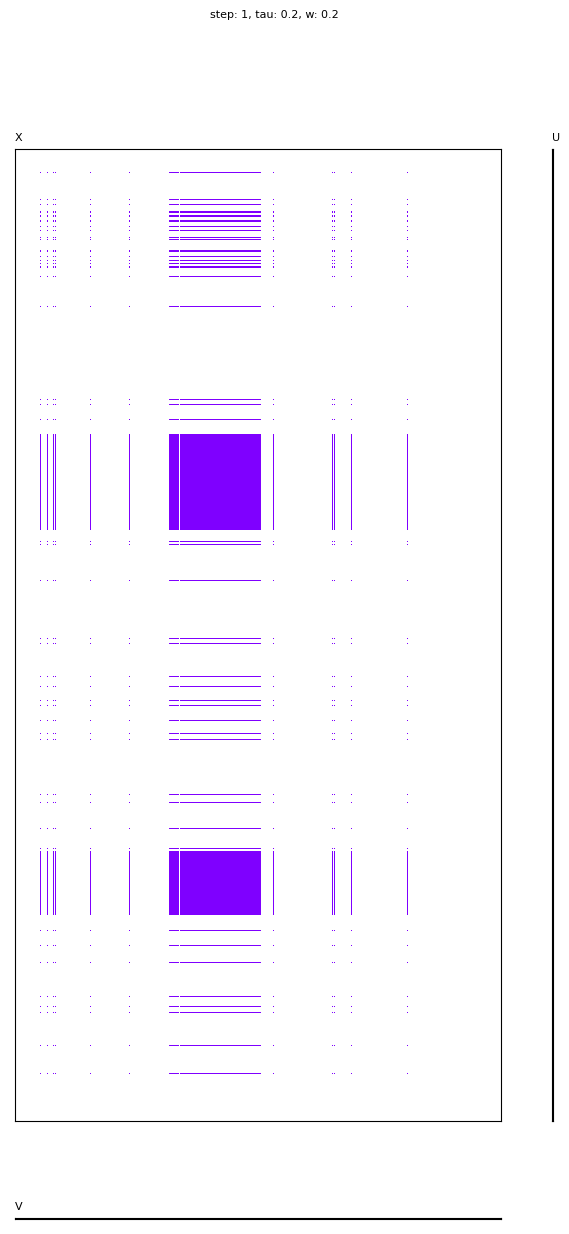

[I] Making predictions: 100%|██████████| 156292/156292 [00:02<00:00, 59010.81it/s]


,time,cover_score,Recall,Precision,Accuracy,F1
0,27/02/24 07:16:39,3181.0,0.098214,0.715218,0.529554,0.172711


[I] Making predictions: 100%|██████████| 22328/22328 [00:00<00:00, 61376.30it/s]


,time,cover_score,Recall,Precision,Accuracy,F1
0,27/02/24 07:16:42,3181.0,0.093157,0.725244,0.528932,0.165106


100%|██████████| 1/1 [00:10<00:00, 10.70s/it]


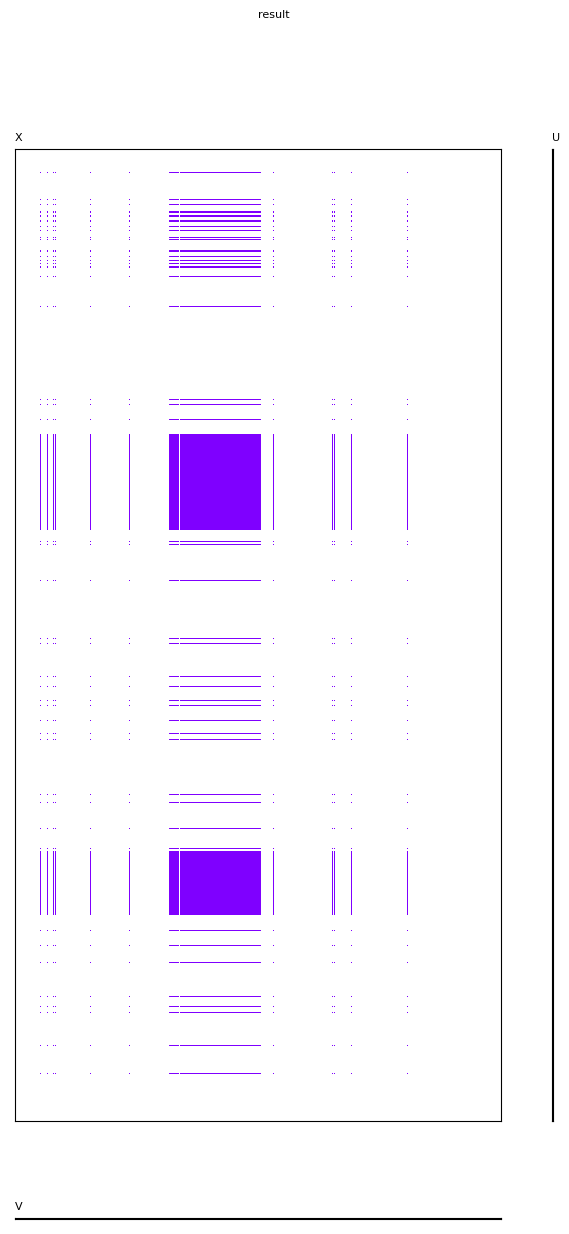

In [28]:
assoori = AssoOri(k=k, tau=tau, w=w)
assoori.fit(X_train, X_val, task='prediction', verbose=True, display=True)

# Asso

In [29]:
asso = Asso(k=k, tau=tau, w=w)
asso.fit(X_train, X_val, task='prediction', verbose=True, display=False)

[I] k            : 1
[I] verbose      : False
[I] display      : False
[I] tau          : 0.2
[I] weights      : 0.2
[I] task         : prediction
[I] verbose      : True


[I] Making predictions: 100%|██████████| 156292/156292 [00:02<00:00, 58150.38it/s]


,time,cover_score,Recall,Precision,Accuracy,F1
0,27/02/24 07:17:17,3181.0,0.098214,0.715218,0.529554,0.172711


[I] Making predictions: 100%|██████████| 22328/22328 [00:00<00:00, 62880.86it/s]


,time,cover_score,Recall,Precision,Accuracy,F1
0,27/02/24 07:17:20,3181.0,0.093157,0.725244,0.528932,0.165106


100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


In [9]:
# profiling

# with Profile() as profile:
#     asso = AssoOri(k=k, tau=tau, w=w)
#     asso.fit(X_train, X_val, task='prediction', verbose=False, display=False)
#     (
#         Stats(profile)
#         .strip_dirs()
#         .sort_stats(SortKey.CALLS)
#         .print_stats()
#     )